In [393]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 8)})
import matplotlib.pyplot as plt
import matplotlib

import os
import re
import pickle
import shutil

from google.cloud import bigquery
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF

2.1.0


In [2]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '~/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project = "livescore-web")

/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [18]:
QUERY = """
SELECT 
    DATE(export_time) as date,
    service.description as description,
    cost_type as costType,
    project.id as id,
    location.country as country,
    location.region as region,
    TIMESTAMP_DIFF(usage_end_time, usage_start_time, MINUTE) as runningTime,
    ROUND(currency_conversion_rate, 2) as conversionRate,
    ROUND(usage.amount, 2) as usageAmount,
    ROUND(cost, 2) AS cost,      
FROM
    `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
ORDER BY 
    date ASC
"""

In [19]:
cost = bigquery_client.query(QUERY).to_dataframe()

In [29]:
cost_sample = cost.sample(n = 1500, replace = False).reset_index(drop = True)

In [3]:
cost_sample = pd.read_csv("cost_sample.csv")

In [43]:
print("Skewness: %f" % cost_sample["cost"].skew())
print("Kurtosis: %f" % cost_sample["cost"].kurt())

Skewness: 36.209679
Kurtosis: 1365.864517


In [216]:
cost_sample = cost_sample.loc[
    (~ cost_sample.country.isna()) &
    (cost_sample.cost >= 0) &
    (~ cost_sample.costType.isna()) &
    (~ cost_sample.region.isna())  &
    (~ cost_sample.usageAmount.isna()) &
    (cost_sample.usageAmount >= 0)
]

In [335]:
cost_sample_cat_onehot = pd.get_dummies(
    cost_sample[["description", "id", "country", "region"]],
    columns = ["description", "id", "country", "region"],
    prefix = ["description", "id", "country", "region"]
)

In [336]:
cost_transformed = pd.concat(
    [cost_sample_cat_onehot, cost_sample[["runningTime", "conversionRate", "usageAmount", "cost"]]], axis = 1
)

In [337]:
print(cost_transformed.head())
print(cost_transformed.describe())

   description_Cloud Composer  description_Cloud Dataflow  \
0                           0                           0   
1                           1                           0   
2                           0                           0   
3                           0                           0   
4                           1                           0   

   description_Cloud Functions  description_Cloud Memorystore for Redis  \
0                            0                                        0   
1                            0                                        0   
2                            0                                        0   
3                            0                                        0   
4                            0                                        0   

   description_Cloud Pub/Sub  description_Cloud SQL  \
0                          0                      0   
1                          0                      0   
2                

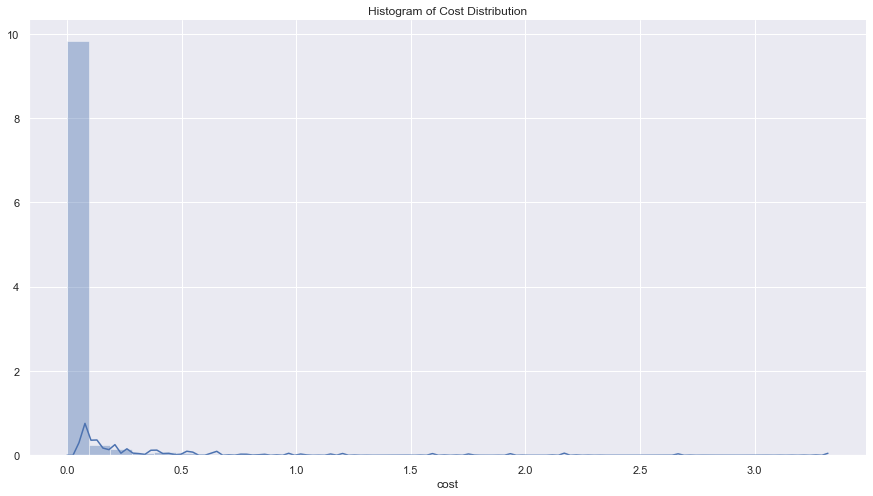

In [239]:
sns.distplot(cost_transformed["cost"])
plt.title("Histogram of Cost Distribution")
sns.despine()

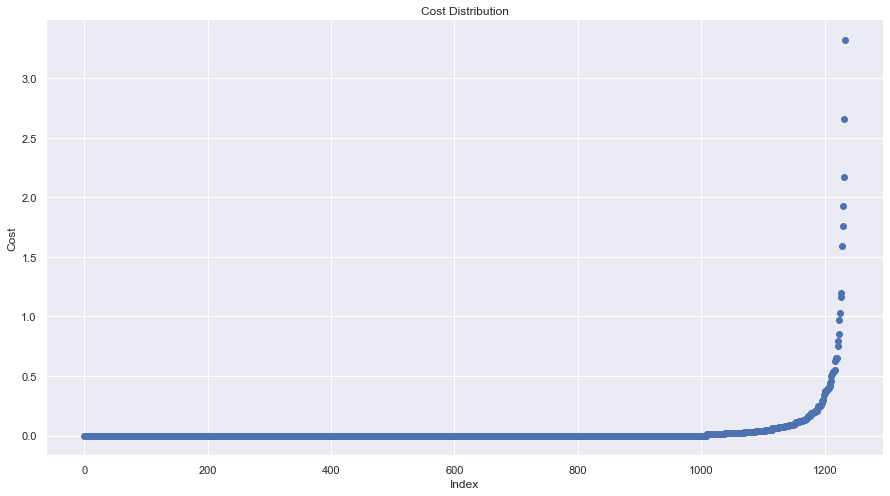

In [240]:
plt.scatter(range(cost_transformed.shape[0]), np.sort(cost_transformed["cost"].values))
plt.xlabel("Index")
plt.ylabel("Cost")
plt.title("Cost Distribution")
sns.despine()

In [340]:
X = cost_transformed[["runningTime", "conversionRate", "usageAmount"]].values
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)
X_minmax = min_max_scaler.transform(X)

In [341]:
X = np.c_[np.array(cost_sample_cat_onehot.values), X_minmax]

In [274]:
principal_component_analysis = PCA(n_components = 2)
principal_component_analysis.fit(X)
X_transformed = principal_component_analysis.fit_transform(X)
print(sum(principal_component_analysis.explained_variance_ratio_))

0.3530375083327867


In [ ]:
classifier = CBLOF(contamination = 0.05, check_estimator = False, random_state = 0)

In [276]:
classifier.fit(X = X_transformed)
scores_pred = classifier.decision_function(X_transformed) * -1
y_pred = classifier.predict(X_transformed)
threshold = np.percentile(scores_pred, 1)

In [277]:
outliers = X_transformed[np.where(y_pred == 1)]
inliers = X_transformed[np.where(y_pred == 0)]

In [278]:
xx, yy = np.meshgrid(
    np.linspace(X_transformed[:, 0].min()-0.25, X_transformed[:, 0].max()+0.25, 100),
    np.linspace(X_transformed[:, 1].min()-0.25, X_transformed[:, 1].max()+0.25, 100)
)
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

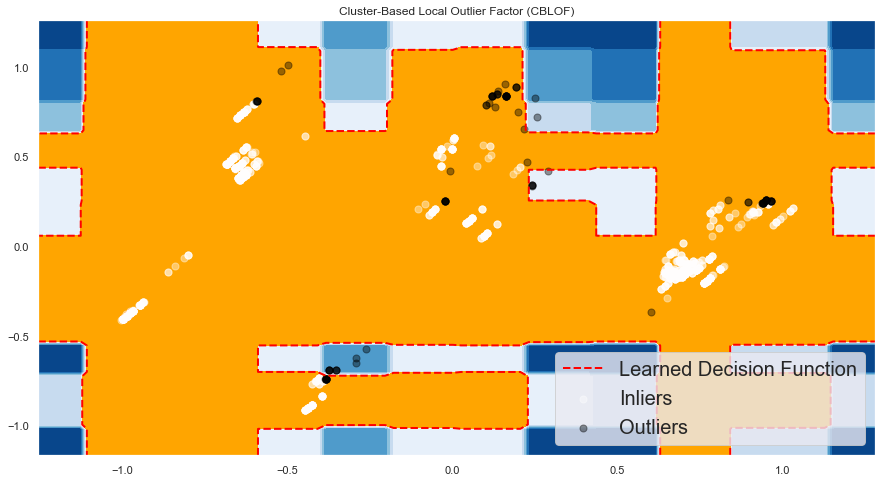

In [280]:
plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7),cmap = plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
plt.contourf(xx, yy, Z, levels = [threshold, Z.max()], colors = 'orange')
b = plt.scatter(inliers[:, 0], inliers[:, 1], c = "white", s = 50, alpha = 0.4, edgecolor = "white")
c = plt.scatter(outliers[:, 0], outliers[:, 1], c = "black", s = 50, alpha = 0.4, edgecolor = "black")

plt.axis("tight")
plt.legend(
    [a.collections[0], b, c], ["Learned Decision Function", "Inliers", "Outliers"],
    prop = matplotlib.font_manager.FontProperties(size = 20), loc = "lower right"
)
plt.title("Cluster-Based Local Outlier Factor (CBLOF)")
plt.show()

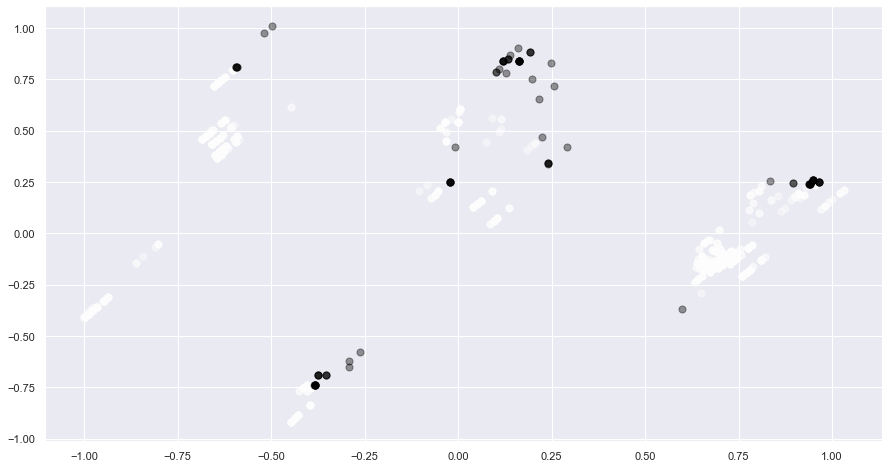

In [281]:
plt.scatter(inliers[:, 0], inliers[:, 1], c = "white", s = 50, alpha = 0.4, edgecolor = "white")
plt.scatter(outliers[:, 0], outliers[:, 1], c = "black", s = 50, alpha = 0.4, edgecolor = "black")